In [2]:
import warnings
from config import KAGGLE_DATA_PATH, KAGGLE_TARGET

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv(KAGGLE_DATA_PATH)
X = df.drop(KAGGLE_TARGET, axis=1)
y = df[KAGGLE_TARGET]

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train:", X_train.shape[0])
print("Test:", X_test.shape[0])

Train: 3539
Test: 885


In [4]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

In [5]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [6]:
def remove_outliers(X_train, y_train):
    from sklearn.ensemble import IsolationForest

    isf = IsolationForest(n_jobs=-1, random_state=1)
    isf.fit(X_train)

    predictions = isf.predict(X_train)

    # The predict method returns 1 for inliers and -1 for outliers.
    X_train_filtered = X_train[predictions == 1]
    y_train_filtered = y_train[predictions == 1]
    return X_train_filtered, y_train_filtered


X_train, y_train = remove_outliers(X_train, y_train)
print("Train after removing outliers:", X_train.shape[0])
print("Test:", X_test.shape[0])

Train after removing outliers: 2907
Test: 885


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier


def select_features_rfe(X_train, y_train, report=True):
    rfe = RFE(estimator=XGBClassifier(n_jobs=-1, random_state=1))
    rfe.fit(X_train, y_train)

    selected_features = X_train.columns[rfe.support_].tolist()

    if report:
        print("Selected Features by RFE:")
        print(selected_features)
        print(len(selected_features))

    return selected_features


def select_features(X_train, top_feats=10, plot=True):
    forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
    forest.fit(X_train, y_train)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    indices = indices[:top_feats]

    if plot:
        plt.figure(figsize=(12, 6))
        plt.title("Top Feature Importances")
        plt.bar(
            range(top_feats),
            importances[indices],
            yerr=std[indices],
            align="center",
            alpha=0.7,
        )
        plt.xticks(range(top_feats), X_train.columns[indices], rotation=90)
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.show()

    return select_features

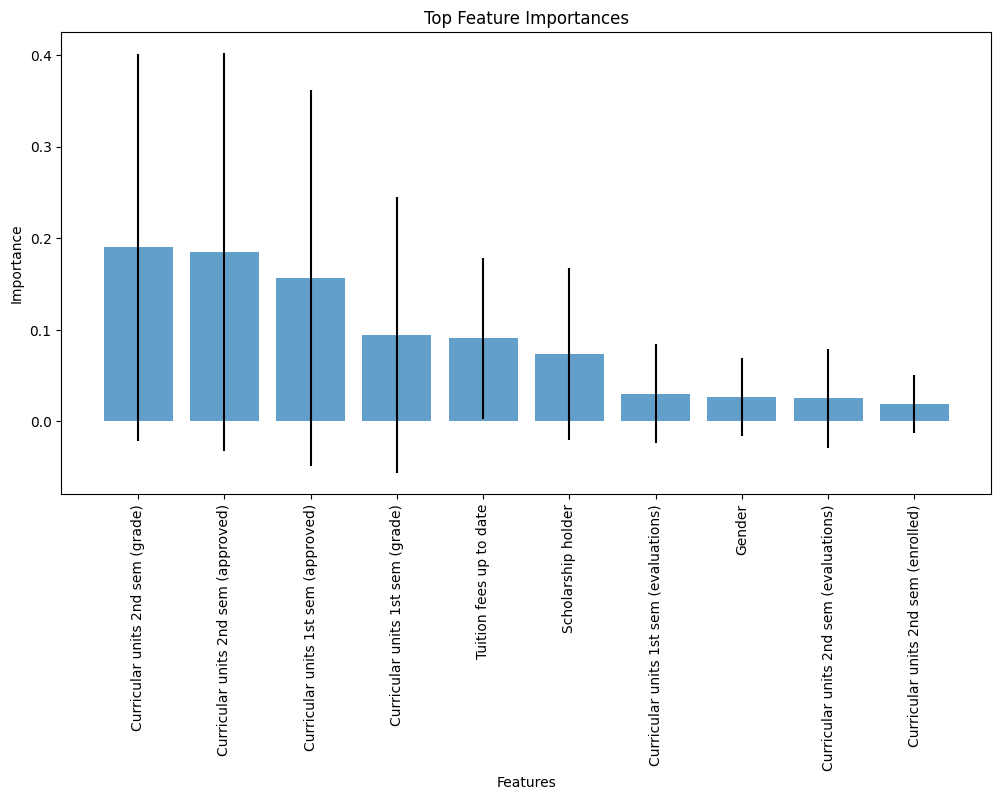

Selected Features by RFE:
['Application mode', 'Course', "Mother's occupation", 'Debtor', 'Tuition fees up to date', 'Scholarship holder', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']
17


In [8]:
selected_features = select_features(X_train)
selected_features_rfe = select_features_rfe(X_train, y_train)

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

## Correlation

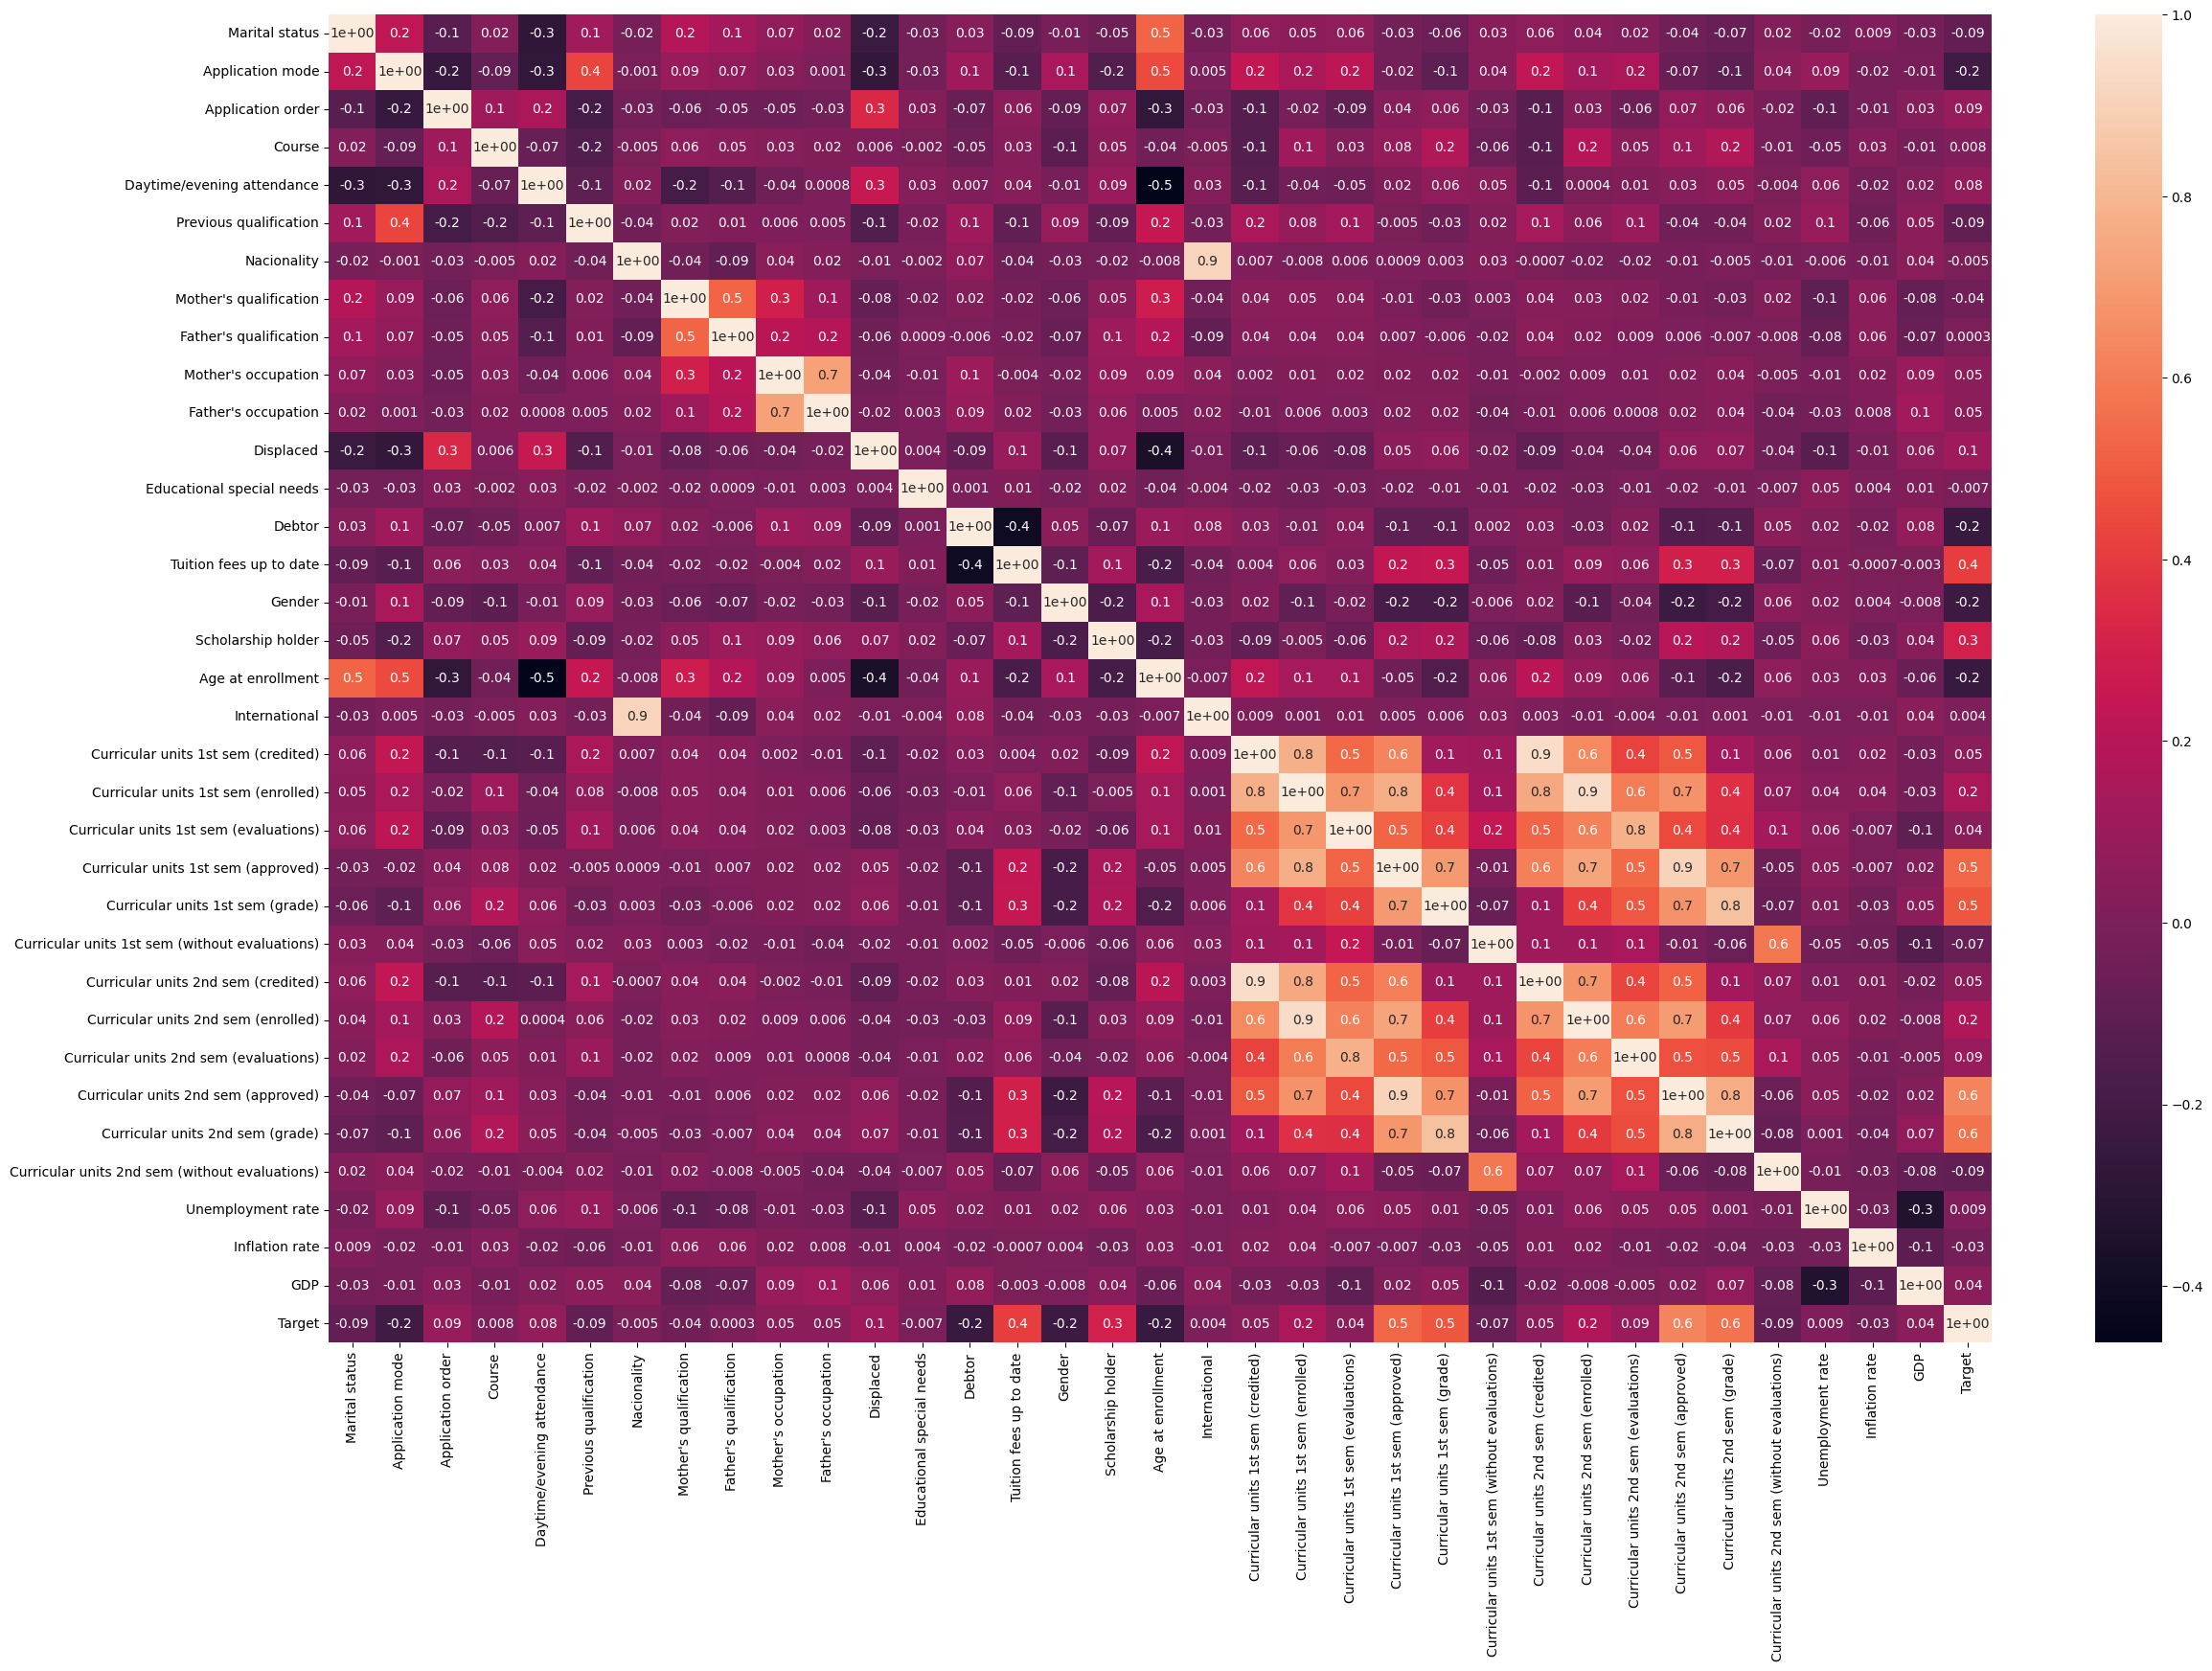

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest

if df[KAGGLE_TARGET].dtype == 'object':
    df[KAGGLE_TARGET] = df[KAGGLE_TARGET].map({
        'Dropout': 0,
        'Enrolled': 1,
        'Graduate': 2
    })

fig, ax = plt.subplots(1, 1, figsize=(28, 18))
sns.heatmap(df.corr(), annot=True, ax=ax, fmt='0.1')
plt.show()

In [22]:
X = df.drop(labels=['Target'], axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Apply Variance Threshold
var_thr = VarianceThreshold(threshold=0.)
var_thr.fit(X_train)
X_train = X_train[X_train.columns[var_thr.get_support()]]
X_test = X_test[X_test.columns[var_thr.get_support()]]

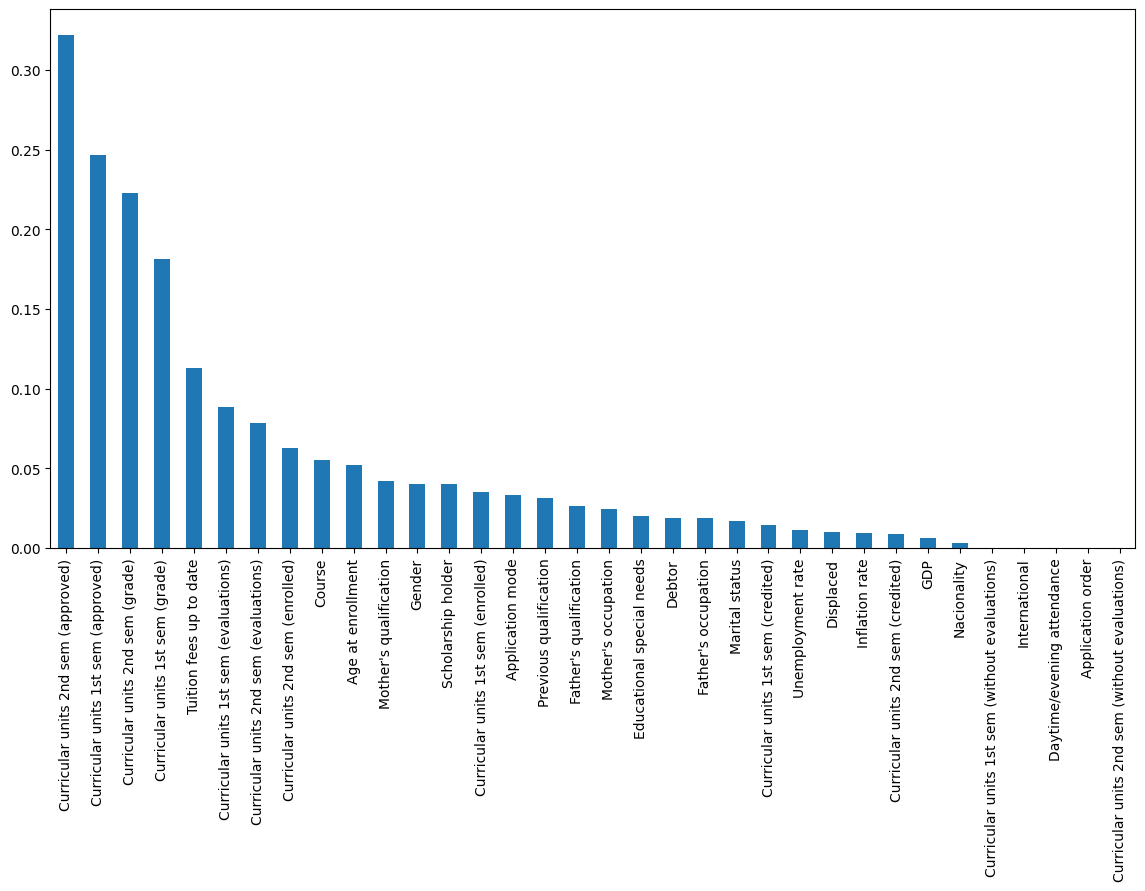

In [33]:
# Compute Mutual Information
mf = mutual_info_classif(X_train, y_train)
mf = pd.Series(mf, index=X_train.columns)
mf.sort_values(ascending=False).plot(kind='bar', figsize=(14, 7))
plt.show()

In [32]:
# Select the top K features based on Mutual Information
K = 10
top_col = SelectKBest(mutual_info_classif, k=K)
top_col.fit(X_train, y_train)
selected_features = X_train.columns[top_col.get_support()]

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

selected_features

Index(['Application mode', 'Course', 'Tuition fees up to date',
       'Scholarship holder', 'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)'],
      dtype='object')

# Oversampling

In [16]:
from oversampling import OversamplingTechniques, oversample_data

X_sm, y_sm = oversample_data(X_train, y_train, OversamplingTechniques.SMOTE)

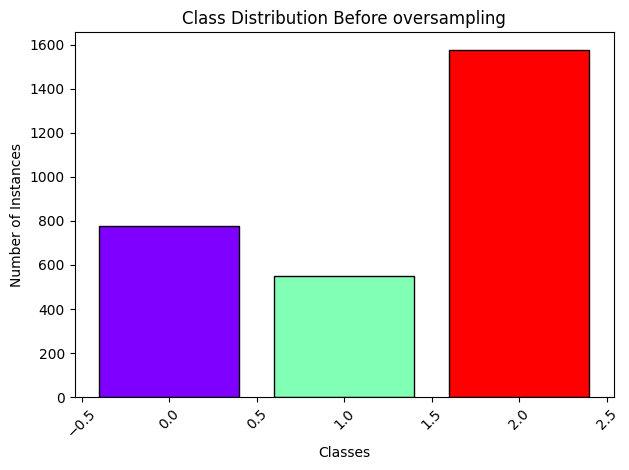

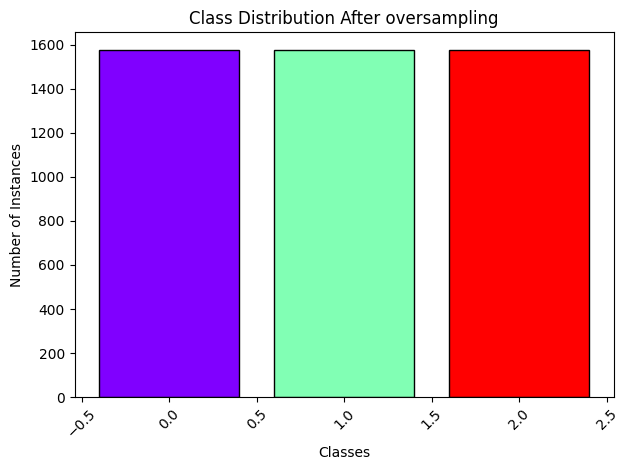

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_labels_counts

def plot_class_distribution(target, title="Class Distribution"):
    unique, counts = get_labels_counts(target)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique)))

    plt.bar(unique, counts, color=colors, edgecolor="black")
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Instances")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_class_distribution(y_train, title="Class Distribution Before oversampling")
plot_class_distribution(y_sm, title="Class Distribution After oversampling")